### Task 2: Temporal Network Analysis
* Degree (in-degree/out-degree)
* Dyads and Reciprocity

A temporal network is goint to be analysed which consists of 678907 vertices and 4729035 edges, where each edge has time information associated with it. Some of the edges have the same source and target vertex, but are association with different timestamps. These timestamps are going to be used in this temporal netwrok analysis to asses and evaluate the evolution of grapg properties by analyzing the changes of the devised measuredby by exploring different time intervals and scales which define time windows to be used.

### <font color="darkgreen">Imports, configuation and preprocessing</font>

In [46]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import math
import igraph
import datetime

In [2]:
temp_nw = pd.read_table("./data/tgraph_real_wikiedithyperlinks.txt", header = None, sep = " ",
                       names = ["src", "trg", "start", "end"])

In [3]:
temp_nw.head()

,src,trg,start,end
0,1,6,1028243088,1120917090
1,1,8,1029885647,1136791625
2,1,9,1029885647,1136791625
3,1,3,1028243088,1143227562
4,1,3,1146727453,1148998304


In [5]:
temp_nw['start'] = pd.to_datetime(temp_nw['start'], unit = 's') #convert Unix timestamps to date time, utc = 0
temp_nw['end'] = pd.to_datetime(temp_nw['end'], unit = 's')

In [6]:
temp_nw.head()

,src,trg,start,end
0,1,6,2002-08-01 23:04:48,2005-07-09 13:51:30
1,1,8,2002-08-20 23:20:47,2006-01-09 07:27:05
2,1,9,2002-08-20 23:20:47,2006-01-09 07:27:05
3,1,3,2002-08-01 23:04:48,2006-03-24 19:12:42
4,1,3,2006-05-04 07:24:13,2006-05-30 14:11:44


In [49]:
wiki = open("data/tgraph_real_wikiedithyperlinks_noTime.txt", 'rb')
G = nx.read_edgelist(wiki, create_using=nx.DiGraph())
wiki.close()

In [50]:
def create_dataframe(G_in):
    df_edge_in = pd.DataFrame(list(G_in.in_degree()), columns=['node', 'in edges'])
    df_edge_out = pd.DataFrame(list(G_in.out_degree()), columns=['node', 'out edges'])
    df_total = pd.merge(df_edge_in, df_edge_out, on='node')
    df_total.index = df_total.index + 1
    return df_total

In [54]:
wiki_df = create_dataframe(G)

We assume that the most changes will be tracked over course of months or years. Let's create a timestamp for every year: $T_i = $ 2002$+i$-01-01 00:00:00.

In [7]:
# Create timestamps
dTime={}
for x in range(0,11):
    year = 2002 + x
    T = datetime.datetime(year, 1, 1, 0, 0, 0)
    dTime["T{0}".format(x)]=T
dTime

{'T0': datetime.datetime(2002, 1, 1, 0, 0),
 'T1': datetime.datetime(2003, 1, 1, 0, 0),
 'T10': datetime.datetime(2012, 1, 1, 0, 0),
 'T2': datetime.datetime(2004, 1, 1, 0, 0),
 'T3': datetime.datetime(2005, 1, 1, 0, 0),
 'T4': datetime.datetime(2006, 1, 1, 0, 0),
 'T5': datetime.datetime(2007, 1, 1, 0, 0),
 'T6': datetime.datetime(2008, 1, 1, 0, 0),
 'T7': datetime.datetime(2009, 1, 1, 0, 0),
 'T8': datetime.datetime(2010, 1, 1, 0, 0),
 'T9': datetime.datetime(2011, 1, 1, 0, 0)}

Now that we have these timestamps, let's generate some graphs, $G_0, G_1, G_2, G_3, G_4, G_5, G_6, G_7, G_8, G_9$, each containing only the edges that appear between $T_i$ and $T_{i+1}$ for $G_i$.

In [9]:
# Create DataFrames for every timestamp
dfG={}
for x in range(0,10):
    T0 = "T{0}".format(x)
    T1 = "T{0}".format(x+1)
    T0 = dTime.get(T0)
    T1 = dTime.get(T1)
    df_G = temp_nw.copy()
    df_G = df_G[((df_G['start'] >= T0) & (df_G['start'] < T1)) | ((df_G['end'] > T0) & (df_G['end'] <= T1)) | 
                ((df_G['start'] < T0) & (df_G['end'] > T1))]
    dfG["df_G{0}".format(x)]=df_G
    print("df_G{0}".format(x) + ": " + str(df_G.shape))

df_G0: (56459, 4)
df_G1: (210603, 4)
df_G2: (502719, 4)
df_G3: (1115759, 4)
df_G4: (1685662, 4)
df_G5: (1758664, 4)
df_G6: (1618639, 4)
df_G7: (1331689, 4)
df_G8: (960662, 4)
df_G9: (443777, 4)


In [10]:
#Create a DataFrame with the amount of edges during every period, so we can visualize it.
lstEdges = list()
lstTime = list()
for x in range(0,10):
    T = "{0}".format(2002+x) + " - " + "{0}".format(2002+x+1) 
    lstTime.append(T)
    df = "df_G{0}".format(x); df = dfG.get(df)
    lstEdges.append(df.shape[0])
edges = pd.DataFrame({'Time': lstTime, 'Edges': lstEdges})
cols = edges.columns.tolist()
cols = cols[-1:] + cols[:-1]
edges = edges[cols]
edges

,Time,Edges
0,2002 - 2003,56459
1,2003 - 2004,210603
2,2004 - 2005,502719
3,2005 - 2006,1115759
4,2006 - 2007,1685662
5,2007 - 2008,1758664
6,2008 - 2009,1618639
7,2009 - 2010,1331689
8,2010 - 2011,960662
9,2011 - 2012,443777


In [11]:
# Initialize a directed graph G from each of the given pandas dataframes.
dG={}
for x in range(0,10):
    G = "df_G{0}".format(x)
    G = dfG.get(G)
    G = nx.from_pandas_dataframe(G, 'src', 'trg', edge_attr=None, create_using=nx.DiGraph())
    dG["G{0}".format(x)]=G

#### Directed Graph used for temporal network analysis (igraph)

Since we also need some functionalities of the $igraph$ library, we are going to make the same graphs in $igraph$.

In [32]:
for x in range(0,10):
    G = "G{0}".format(x); G = dG.get(G)
    nx.write_gml(G, 'data/gml_G{0}.gml'.format(x))

G_i0 = igraph.Graph.Read_GML('data/gml_G0.gml')
G_i1 = igraph.Graph.Read_GML('data/gml_G1.gml')
G_i2 = igraph.Graph.Read_GML('data/gml_G2.gml')
G_i3 = igraph.Graph.Read_GML('data/gml_G3.gml')
G_i4 = igraph.Graph.Read_GML('data/gml_G4.gml')
G_i5 = igraph.Graph.Read_GML('data/gml_G5.gml')
G_i6 = igraph.Graph.Read_GML('data/gml_G6.gml')
G_i7 = igraph.Graph.Read_GML('data/gml_G7.gml')
G_i8 = igraph.Graph.Read_GML('data/gml_G8.gml')
G_i9 = igraph.Graph.Read_GML('data/gml_G9.gml')

In [339]:
igraph_networks = [G_i0, G_i1, G_i2, G_i3, G_i4, G_i5, G_i6, G_i7, G_i8, G_i9]

In [45]:
len(list(G_i0.vs)) == len(list(dG.get('G0'))) # just a random check

True

### <font color="darkgreen">1. Temporal Network Analysis:</font> Degree distribution

In the static network analysis we have some interesting correlations between the degree distribution and certain pecularities of (group of) nodes and the graph in general. In this section we are going to state some hypotheses based on the context of the to be analyzed temporal data based and the insights we gained in the static network analysis. Since we are considering a network of pages with the nodes representing pages while the links represent links between the pages of a certain website/domain we expect there to be notable changes in time intervals of a year. This assumption was confirmed when we looked at the changes in the introduction of this task.

Let's formulate a hypothesis about the the temperal changes in the degree distribution over the devised time intervals in relation to our knowledge of the context of the network. In the static network analysis it was observed that there was a rather niche group of edges with a relatively high number of incoming edges compared to the averag in-degree of the rest of the network. The same goes for out-degree, there was also a rather small group of nodes in the network with a very high number of outgoing edges compared to the average out-degree found in the dataset

Let's query these nodes for further assessment in the context of the temporal network analysis.

In [55]:
sorted_incoming_edges = wiki_df.sort_values(['in edges']).reset_index(drop = True)
incoming_edges_top_1 = sorted_incoming_edges.iloc[99 * math.floor(sorted_incoming_edges.shape[0] / 100):]

In [56]:
sorted_outgoing_edges = wiki_df.sort_values(['out edges']).reset_index(drop = True)
outgoing_edges_top_1 = sorted_outgoing_edges.iloc[99 * math.floor(sorted_outgoing_edges.shape[0] / 100):]

In [241]:
top_1_incoming_edges = list(incoming_edges_top_1.node)
top_1_outgoing_edges = list(outgoing_edges_top_1.node)
print(top_1_incoming_edges[-10:])
print(top_1_outgoing_edges[-10:])

['125', '740', '240', '442', '241', '300', '3546', '146', '149', '394']
['970034', '16115', '598952', '707633', '9273', '707642', '377365', '9258', '154856', '306188']


In [247]:
top_1_in = [int(node) for node in top_1_incoming_edges]
top_1_out = [int(node) for node in top_1_outgoing_edges]

Now the static network analysis did not take time-stamps into consideration, but we can still conclude what in general, are relatively 'popular' pages in the graph and/or pages with a lot of outgoing links (hubs). That is exactly what the point is of these queries. 

The assumption is that pages that are relatively popular will change more than when you pick the same number of nodes at random in the network. This temporal network analysis of the degree distribtion is, therefore, going to be focused on this assumption.

It can be of course, that certain pages are added/removed during the different time-intervals even though this are probably not going to be the nodes that we just selected. But as we can see in the graph below, the top 1% vertices sorted on incoming-edges in graph remains in the network over the year, which makes sense of course.

In [242]:
for df_g in dG:
    nodes_in_graph = set(dG.get(df_g).node)
    
    top_1_incoming_common = list(set(top_1_in).intersection(nodes_in_graph))
    print("nodes in graph: ", len(nodes_in_graph), " top 1% vertices sorted on incoming-edges in graph: ", len(top_1_incoming_common))
    top_1_outgoing_common = list(set(top_1_out).intersection(nodes_in_graph))
    print("nodes in graph: ", len(nodes_in_graph), " top 1% vertices sorted on outgoing-edges in graph: ", len(top_1_outgoing_common))

nodes in graph:  18672  top 1% vertices sorted on incoming-edges in graph:  3510
nodes in graph:  18672  top 1% vertices sorted on outgoing-edges in graph:  1953
nodes in graph:  53246  top 1% vertices sorted on incoming-edges in graph:  5362
nodes in graph:  53246  top 1% vertices sorted on outgoing-edges in graph:  3269
nodes in graph:  112997  top 1% vertices sorted on incoming-edges in graph:  6069
nodes in graph:  112997  top 1% vertices sorted on outgoing-edges in graph:  4267
nodes in graph:  226490  top 1% vertices sorted on incoming-edges in graph:  6506
nodes in graph:  226490  top 1% vertices sorted on outgoing-edges in graph:  5254
nodes in graph:  346339  top 1% vertices sorted on incoming-edges in graph:  6632
nodes in graph:  346339  top 1% vertices sorted on outgoing-edges in graph:  5913
nodes in graph:  415173  top 1% vertices sorted on incoming-edges in graph:  6674
nodes in graph:  415173  top 1% vertices sorted on outgoing-edges in graph:  6295
nodes in graph:  440

We thus know that the defined top 1% on incoming edges and the top 1% on outgoing edges both have 6796 nodes and that these nodes appear quite frequent in the ten networks of the different years, which is expected. Especially from nodes with a high number of incoming edges since these would be should be quite popular pages. The next step is in the evaluation of the hypothesis is to select the same number of nodes, at random, that also appear in the network of all the years, excluding these 6796 nodes. 

In [243]:
all_nodes = set(wiki_df.node); print("number of nodes accross all years: ", len(all_nodes))
all_nodes = all_nodes.difference(set(top_1_incoming_edges))
all_nodes = all_nodes.difference(set(top_1_outgoing_edges))

number of nodes accross all years:  678907


In [244]:
random_selected_nodes = {int(node) for node in all_nodes}

The next step is to iterate over all the networks of all the years and assess which nodes also appear in all the networks.

In [245]:
for df_g in dG:
    global random_selected_nodes
    nodes_in_graph = set(dG.get(df_g).node)
    random_selected_nodes = random_selected_nodes.intersection(nodes_in_graph)

len(random_selected_nodes)

7109

Coincidentally, this is just enough to select 6796 random nodes (but we need a bit less for each year as we have seen before) out of this collection (note that we have already removed the two size-6976 top collections out of the collection before the intersection with the nodes of the various networks.) While there is already a lot of randomness introduced, we will also remove the last set of nodes at random to end up with a collection of len randomly selected nodes to evaluate the change of the degree of these nodes over time compared to the top groups that were devised. This will be done at each seperately to make sure that we evaluate the same number of nodes in each year, depending on the number of nodes of the top in/out-going groups in those particular years.

In [206]:
import random; random.seed(88)

Note that random sampling function does random sampling without replacement, so there is no risk of having the same node twice in the collection.

The next step is to actually test our hypothesis. The choice is made to do this by comparing visualizations of the change over the selected time-intervals (years), asses absolute changes over the intervals and lastly to asses relative changes in these intervals.

In [262]:
def comparing_methods(random_nodes):
    dict_values_all_years = {}
    for network in dG:
        dict_values = {}
        G_year = dG.get(network)
        
        nodes_network =  set(G_year.node)
        nodes_intersection_in = list(set(top_1_in).intersection(nodes_network))
        number_of_nodes_in = len(nodes_intersection_in)
        nodes_intersection_out = list(set(top_1_out).intersection(nodes_network))
        number_of_nodes_out = len(nodes_intersection_out)
        
        if(random_nodes):
            nodes_intersection_in = random.sample(population = list(nodes_network), k = number_of_nodes_in)
            nodes_intersection_out = random.sample(population = list(nodes_network), k = number_of_nodes_out)
        
        in_degree_nodes = [G_year.in_degree(node) for node in nodes_intersection_in]
        out_degree_nodes = [G_year.out_degree(node) for node in nodes_intersection_out]
        
        dict_values['number_of_nodes_in'] = number_of_nodes_in
        dict_values['number_of_nodes_out'] = number_of_nodes_out
        
        total_in = sum(in_degree_nodes); total_out = sum(out_degree_nodes)
        dict_values['total_in_degree'] = total_in
        dict_values['total_out_degree'] = total_out
        
        avg_in_degree = round(total_in / len(nodes_intersection_in), 3)
        avg_out_degree = round(total_out / len(nodes_intersection_out), 3)
        dict_values['avg_in_degree'] = avg_in_degree
        dict_values['avg_out_degree'] = avg_out_degree
        
        dict_values_all_years[network] = dict_values
    return dict_values_all_years

In [291]:
random_nodes_values = comparing_methods(random_nodes = True)
print(random_nodes_values)

{'G0': {'number_of_nodes_in': 3510, 'number_of_nodes_out': 1953, 'total_in_degree': 10146, 'total_out_degree': 6124, 'avg_in_degree': 2.891, 'avg_out_degree': 3.136}, 'G1': {'number_of_nodes_in': 5362, 'number_of_nodes_out': 3269, 'total_in_degree': 19737, 'total_out_degree': 10796, 'avg_in_degree': 3.681, 'avg_out_degree': 3.303}, 'G2': {'number_of_nodes_in': 6069, 'number_of_nodes_out': 4267, 'total_in_degree': 24443, 'total_out_degree': 19463, 'avg_in_degree': 4.028, 'avg_out_degree': 4.561}, 'G3': {'number_of_nodes_in': 6506, 'number_of_nodes_out': 5254, 'total_in_degree': 29535, 'total_out_degree': 21901, 'avg_in_degree': 4.54, 'avg_out_degree': 4.168}, 'G4': {'number_of_nodes_in': 6632, 'number_of_nodes_out': 5913, 'total_in_degree': 24847, 'total_out_degree': 22990, 'avg_in_degree': 3.747, 'avg_out_degree': 3.888}, 'G5': {'number_of_nodes_in': 6674, 'number_of_nodes_out': 6295, 'total_in_degree': 27954, 'total_out_degree': 24504, 'avg_in_degree': 4.188, 'avg_out_degree': 3.893},

In [266]:
top_groups_values = comparing_methods(random_nodes = False) # in other words, use top 1% incoming/outgoing edges nodes
print(top_groups_values)

{'G0': {'number_of_nodes_in': 3510, 'number_of_nodes_out': 1953, 'total_in_degree': 29260, 'total_out_degree': 31631, 'avg_in_degree': 8.336, 'avg_out_degree': 16.196}, 'G1': {'number_of_nodes_in': 5362, 'number_of_nodes_out': 3269, 'total_in_degree': 100687, 'total_out_degree': 102102, 'avg_in_degree': 18.778, 'avg_out_degree': 31.233}, 'G2': {'number_of_nodes_in': 6069, 'number_of_nodes_out': 4267, 'total_in_degree': 234083, 'total_out_degree': 203028, 'avg_in_degree': 38.57, 'avg_out_degree': 47.581}, 'G3': {'number_of_nodes_in': 6506, 'number_of_nodes_out': 5254, 'total_in_degree': 510990, 'total_out_degree': 364517, 'avg_in_degree': 78.541, 'avg_out_degree': 69.379}, 'G4': {'number_of_nodes_in': 6632, 'number_of_nodes_out': 5913, 'total_in_degree': 667743, 'total_out_degree': 482145, 'avg_in_degree': 100.685, 'avg_out_degree': 81.54}, 'G5': {'number_of_nodes_in': 6674, 'number_of_nodes_out': 6295, 'total_in_degree': 678231, 'total_out_degree': 516011, 'avg_in_degree': 101.623, 'av

In [310]:
def visualize_changes(dict_values1, dict_values2):
    number_of_nodes_in1 = number_of_nodes_out1 = total_in_degree1 = total_out_degree1 = np.empty((0, 10), dtype = int)
    avg_in_degree1 = avg_out_degree1 = np.empty((0, 10), dtype = float)
    
    number_of_nodes_in2 = number_of_nodes_out2 = total_in_degree2 = total_out_degree2 = np.empty((0, 10), dtype = int)
    avg_in_degree2 = avg_out_degree2 = np.empty((0, 10), dtype = float)
    
    for network_year in dG:
        values_year1 = dict_values1.get(network_year)
        number_of_nodes_in1 = np.append(number_of_nodes_in1, [values_year1.get('number_of_nodes_in')])
        number_of_nodes_out1 = np.append(number_of_nodes_out1, [values_year1.get('number_of_nodes_out')])
        total_in_degree1 = np.append(total_in_degree1, [values_year1.get('total_in_degree')])
        total_out_degree1 = np.append(total_out_degree1, [values_year1.get('total_out_degree')])
        avg_in_degree1 = np.append(avg_in_degree1, [values_year1.get('avg_in_degree')])
        avg_out_degree1 = np.append(avg_out_degree1, [values_year1.get('avg_out_degree')])
        
        values_year2 = dict_values2.get(network_year)
        number_of_nodes_in2 = np.append(number_of_nodes_in2, [values_year2.get('number_of_nodes_in')])
        number_of_nodes_out2 = np.append(number_of_nodes_out2, [values_year2.get('number_of_nodes_out')])
        total_in_degree2 = np.append(total_in_degree2, [values_year2.get('total_in_degree')])
        total_out_degree2 = np.append(total_out_degree2, [values_year2.get('total_out_degree')])
        avg_in_degree2 = np.append(avg_in_degree2, [values_year2.get('avg_in_degree')])
        avg_out_degree2 = np.append(avg_out_degree2, [values_year2.get('avg_out_degree')])
        
    return [(total_in_degree1, total_in_degree2), (total_out_degree1, total_out_degree2),
            (avg_in_degree1, avg_in_degree2), (avg_out_degree1, avg_out_degree2)] # facilitates easy and strucuted comparison

In [304]:
years = np.arange(10)

In [311]:
list_of_comparisons = visualize_changes(top_groups_values, random_nodes_values)

Change number of total in degree among nodes

Top groups (green) vs Random group (red)



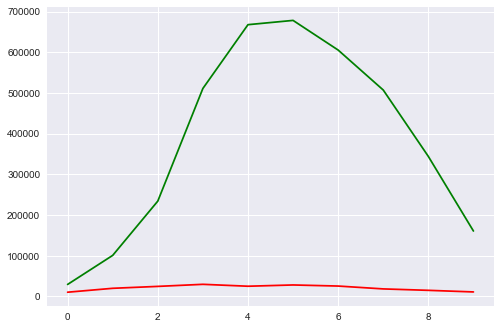

Random group (equal size) (again, in blue; to display growth pattern



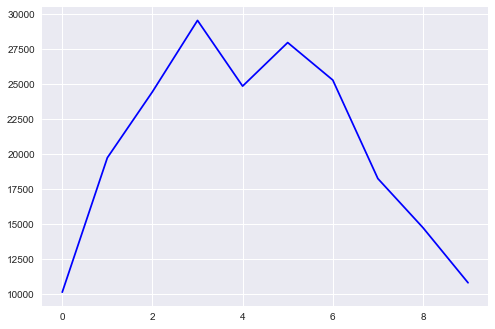

In [334]:
# total in degree comparison
tuple_comp = list_of_comparisons[0]
print("Change number of total in degree among nodes\n")
print("Top groups (green) vs Random group (red)\n")
plt.plot(years, tuple_comp[0], 'g')
    
plt.plot(years, tuple_comp[1], 'r')
plt.show()

print("Random group (equal size) (again, in blue; to display growth pattern\n")
plt.plot(years, tuple_comp[1], 'b')
plt.show() 

In the first one can see the change of the total in-degree of all the nodes in the network of 1) The top-group nodes in green 2) a random group of the network of same size as the top group in red. Obviously, the total in-degree of the first group is a lot bigger than that of the random group of nodes considering the fact that they were selected on this criteria. 
The noteworthy thing can be observed when one involves the second plot into the picture. This plot is the growth of the random group, properly scaled according to its range of values whereas the form of the graph was not observable in the first plot. We see that even though the random group has much lower value, it follow more or less the same growth and decline patern (relative to its values) when compared to growth of the top group. We should be cautious of deriving ungrounded conclusions from this observation, but one possible explanation for this is that the growth of the in-degree of an average node (i.e. the number of a pages linking to this page) follows more or less the same growth <b>pattern</b> (relatively) as any other node in the network, while we can see that the top-group has a steadier rate of growth and decline than the random group. 

If we try to place this in the context of a network representing pages of a particular domain, one can <i>possibly</i> explain these pheneomena by the exploitation of divergent thinking. One can image that the majority of the pages have more or less the same layout (i.e. framework) whereas only the information on the page (including links to other pages) differs. A page on WikiPedia about "Donald Trump" will for example have a lot more information and links on it than a page on "Degree distribution". The pages are, however, placed in the same number WikiPedia 'framework' which also contains a lot of links. WikiPedia, for example, has a lot of navigational links on the top, left and bottom of the page. If the number of links of the links in this consistent framework would change over time, and if these links are indeed included in the network, than this would greatly affect the observable growths in such graphs. This is, however, strictly hypothetical and just an elaboration which tries to find an explanation for the observations.

Change number of total out degree among nodes

Top groups (green) vs Random group (red)



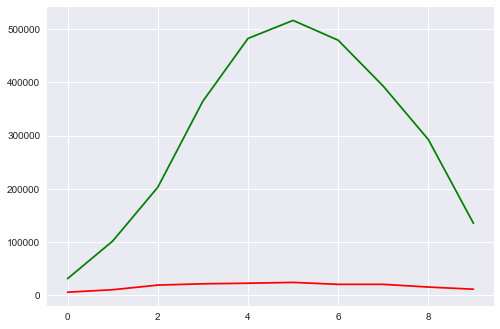

Random group (equal size) (again, in blue; to display growth pattern



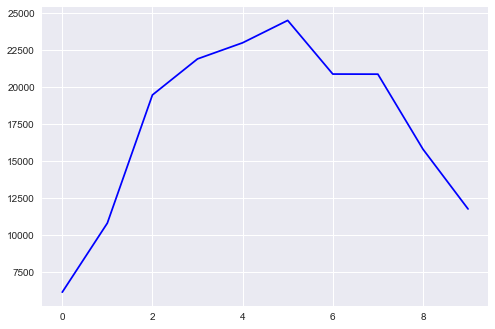

In [336]:
# total out degree comparison
tuple_comp = list_of_comparisons[1]
print("Change number of total out degree among nodes\n")
print("Top groups (green) vs Random group (red)\n")
plt.plot(years, tuple_comp[0], 'g')
    
plt.plot(years, tuple_comp[1], 'r')
plt.show()

print("Random group (equal size) (again, in blue; to display growth pattern\n")
plt.plot(years, tuple_comp[1], 'b')
plt.show() 

One can draw more or less the same conclusion as for the out-degree comparison as for the in-degree comparison. The noteworthy thing which is quite trivial is that the rate of growh of the top-group follows more or less the same growth pattern as the previous group. We have in the static analysis thar there was a strong relation between these two groups which is a possible explanation for this. The random group show the same growth more or less, but shows a bit shifty growth and decline compared to the top group.

Change average in degree among nodes

Top groups (green) vs Random group (red)



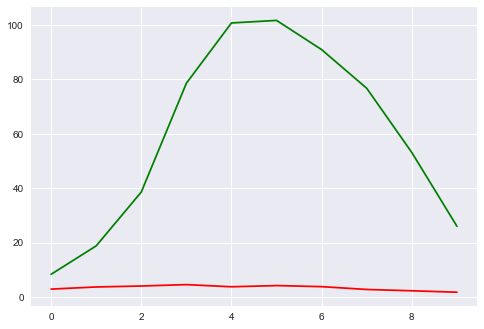

Random group (equal size) (again, in blue; to display growth pattern



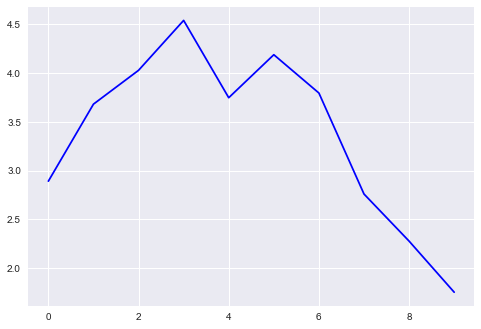

In [337]:
# average in degree comparison
tuple_comp = list_of_comparisons[2]
print("Change average in degree among nodes\n")
print("Top groups (green) vs Random group (red)\n")
plt.plot(years, tuple_comp[0], 'g')
    
plt.plot(years, tuple_comp[1], 'r')
plt.show()

print("Random group (equal size) (again, in blue; to display growth pattern\n")
plt.plot(years, tuple_comp[1], 'b')
plt.show() 

Change average out degree among nodes

Top groups (green) vs Random group (red)



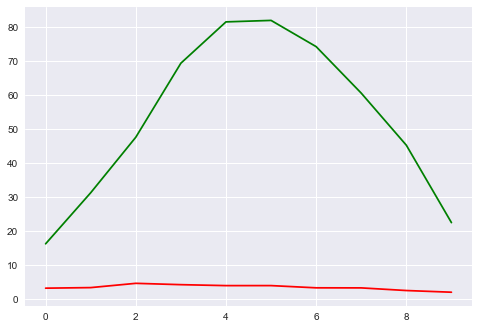

Random group (equal size) (again, in blue; to display growth pattern



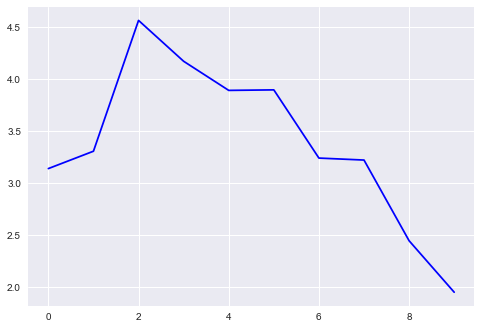

In [338]:
# average out degree comparison
tuple_comp = list_of_comparisons[3]
print("Change average out degree among nodes\n")
print("Top groups (green) vs Random group (red)\n")
plt.plot(years, tuple_comp[0], 'g')
    
plt.plot(years, tuple_comp[1], 'r')
plt.show()

print("Random group (equal size) (again, in blue; to display growth pattern\n")
plt.plot(years, tuple_comp[1], 'b')
plt.show() 

The graphs of the average in and out degree of the top groups compared to the random groups of same size show even more interesting insights in the evolution of the degree distribution of this network over time when focussing on certain groups/types of nodes (i.e. pages). 

The first thing to notice from all of these graphs is that the one can learn a lot about the growth or decline of such a network over time by looking at the 'top-groups' of the network. The relative growth or decline of the in- or out-degree of a node which has a relatively high average in- or out-degree ignoring the time (i.e. static network analysis over a large period) shows that these groups of nodes (i.e. pages) give good insight on the average growth of the in- or out-degree of the rest of the nodes in the network (on average), the growht of these groups does affect the average of course, but we can see in the previous graphs that the same growth pattern can be obersved when strictly focussing on a group of random nodes. It is, therefore, scientifically sound to assume or state such a correlation, even though one cannot confirm this hypothesis without the usage of meta-data / more information about the nodes (i.e. pages) in the network.

The second thing worth noting is that we can not confirm the initial hypothesis based on the graphs. While the top-groups seem to be leading the overall change in the network, it is the random nodes that seem to show more shifty growth and decline as can be seen in the last few graphs.

### <font color="darkgreen">2. Temporal Network Analysis:</font> Dyads and Reciprocity

In the static network analysis we have seen gained some interesting insights using the Dyad Census and Reciporocity measures on the network. These metrics can be used to measure how frequent nodes (i.e pages) have a symmetric link between each other, or how frequent one has a one-way link between nodes in the network. It boils down to classifying each pair of nodes $u$ and $v$ in the network (i.e. a directed graph in our context) into three categories, which are:

1. <b>Mutual:</b> There is an edge from $u$ to $v$ and also an edge frome $v$ to $u$
2. <b>Asymmetric:</b> There is either an edge from $u$ to $v$ or an edge from $v$ to $u$
3. <b>Null:</b> There is no edge from $u$ to $v$ and also no edge frome $v$ to $u$


We have seen the effect of self-loops and parallel edges on these measures, which were pecularities we had to deal with because we were doing a static network analyis of an evolving graph.

The conclusions in the static network analysis was that a lot of pages do not have an (asymmetric) link to each other, and in addition, the number of pages that link to each other (i.e. mutual) are even less common. This actually does make sense when one considers the context of a network of a website/domain. One would not expect that every page has a link to every other page in the network, especially considering the size of this particular network. In addition, having mutual edges on a website depends entirely on the type of webpages one is considering. For some webpages it makes sense considering the navigation of the website. Or consider pages on WikiPedia which refer to a sub-topic of certain topic. This sub-topic is likely to have also a link back to the main topic.

In this temporal network analysis the next step is to see whether we can observe the same things, and to assess whether we can gain some insights on how these measures change over time in such a network.

We have already splitted the network in the respective periods and have given motivation for these particular division of time-scales. Let's see whether we can observe some noteworthy things when using the same time-scales or assess whether another time scale would be more appropriate for these measures.

In [344]:
len(G_i0.vs)

18672

In [346]:
asymmetric = np.empty((0, 10), dtype = int)
mutual = np.empty((0, 10), dtype = int)
size_network = np.empty((0, 10), dtype = int)
years = np.arange(10)

for network in igraph_networks:
    graph_dyad_census = network.dyad_census()
    graph_dyad_census = sorted(graph_dyad_census.as_dict().items())[:2]
    asymmetric = np.append(asymmetric, graph_dyad_census[0][1])
    mutual = np.append(mutual, graph_dyad_census[1][1])
    size_network = np.append(size_network, len(network.vs))
    print(graph_dyad_census)

[('asymmetric', 44446), ('mutual', 5263)]
[('asymmetric', 166906), ('mutual', 16357)]
[('asymmetric', 414331), ('mutual', 25706)]


C:\ProgramData\Anaconda3\lib\site-packages\igraph\__init__.py:512: RuntimeWarning: Integer overflow, returning zero at src\motifs.c:899
  return DyadCensus(GraphBase.dyad_census(self, *args, **kwds))


[('asymmetric', 938564), ('mutual', 31558)]
[('asymmetric', 1351548), ('mutual', 38606)]
[('asymmetric', 1491190), ('mutual', 38506)]
[('asymmetric', 1392472), ('mutual', 24196)]
[('asymmetric', 1179987), ('mutual', 18181)]
[('asymmetric', 847469), ('mutual', 12133)]
[('asymmetric', 386173), ('mutual', 5044)]


The integer overflow occurs due to the null values it tries to calculate for relatively large networks. Null represents the number of missing links between every pair $u$ and $v$, a measure we are not really interested in considering the huge size of the networks and the fact this can be derived from the other meausures.

In [347]:
print(asymmetric)
print(mutual)
print(size_network)

[  44446  166906  414331  938564 1351548 1491190 1392472 1179987  847469
  386173]
[ 5263 16357 25706 31558 38606 38506 24196 18181 12133  5044]
[ 18672  53246 112997 226490 346339 415173 440817 416688 362955 221517]


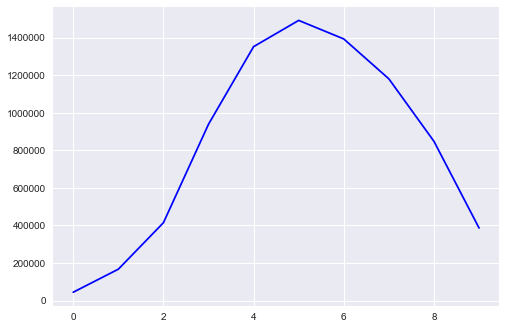

In [351]:
# growth/decline of asymmetric values
plt.plot(years, asymmetric, 'b')
plt.show()

It makes sense, of course, to look at the relative growth and thus correct the values for the respective network size in the particular time-intervals.

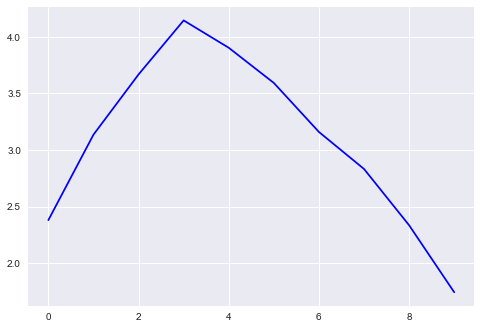

In [352]:
# growth/decline of asymmetric values
asymmetric_relative = [((x * 1.0) / y) for x, y in zip(asymmetric, size_network)]
plt.plot(years, asymmetric_relative, 'b')
plt.show()

And the same for the change of the mutual relations in the network over the years.

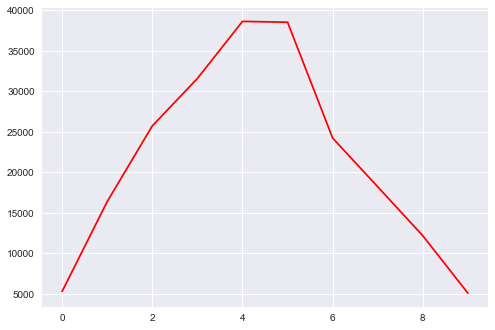

In [354]:
# growth/decline of mutual values
plt.plot(years, mutual, 'r')
plt.show()

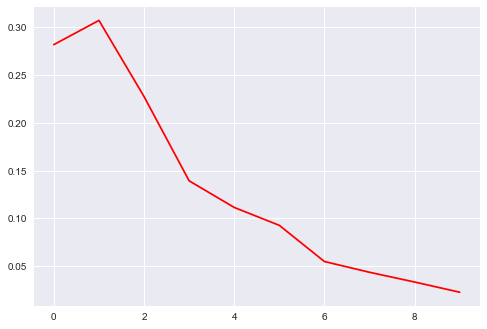

In [356]:
# growth/mutual of mutual values
mutual_relative = [((x * 1.0) / y) for x, y in zip(mutual, size_network)]
plt.plot(years, mutual_relative, 'r')
plt.show()

There are some noteworthy things tha we can see from the relative growth graphs. Note that one should not derive any conclusions from the graph themselves since the values are divide by the changin number of nodes over time. The relative graphs should only be used to compare the changes of the two metrics over time.

The first thing worth noting is the growth pattern of the asymmetric links in the graph. This seems to be in line with the growth patterns we have seen for the degree(-distribution) analysis in the previous paragraph, so it is quite evident that this change correlates with the in/out-degree. 

The mutual connections, which are much smaller portion of the total amount of edges in the network show that the relative number of mutual edges has declined over time, not following the growth patterns we have seen earlier on. This means that the network contains relatively less and less pages that have a mutual link to each other. We can try to place this in the context of the network again. It could be that the relative amount of mutual edges has declined due to policies on a certain domain (i.e. network) which try to limit or prohibit returning edges as much as possbile. Another possible reason can be that as new pages (e.g. topics) get added to the network, the network will contain relatively new information (e.g. events in the world, people becoming famous, new discoveries in science etc.) because othrtwise there would alrady have been a page about this topic on the network. And if there is for example a new page in the network about a relatively topic $T$, then there will be probably (assumption) less (mutual) links to this network from original nodes already present in the network since the topic that is covered contains relatively new concepts and/or events. This is, however, strictly hypothetical. We try to link the insights to the context of the network as much as possible, but are well aware of the fact that we should be cautious with our statements considering the limited amount of context given of the network. 